In [1]:
import psycopg2
import pandas as pd
import yaml

class DBConnectionInfo:
    def __init__(self):
        with open("connection.yml", "r") as f:
            config = yaml.load(f, yaml.FullLoader)
            self.host = config["host"]
            self.port = config["port"]
            self.database = config["database"]
            self.user = config["user"]
            self.password = config["password"]


def export_table_to_pd(table_name):
    # 连接到 PostgreSQL 数据库
    db_connection_info = DBConnectionInfo()
    conn = psycopg2.connect(host=db_connection_info.host, port=db_connection_info.port, database=db_connection_info.database,
                            user=db_connection_info.user, password=db_connection_info.password)
    cursor = conn.cursor()

    # 查询表的字段信息
    cursor.execute(f"SELECT column_name \
            FROM information_schema.columns \
            WHERE table_name = '{table_name}';")
    columns = [row[0] for row in cursor.fetchall()]

    # 查询表的数据
    cursor.execute(f"SELECT {', '.join(columns)} \
            FROM {table_name};")
    rows = cursor.fetchall()

    # 将数据转换为字典列表
    df = pd.DataFrame(rows, columns=columns)

    # 关闭数据库连接
    cursor.close()
    conn.close()

    return df

In [2]:
poll_vote = export_table_to_pd("misago_threads_pollvote")
poll = export_table_to_pd("misago_threads_poll")
thread = export_table_to_pd("misago_threads_thread")

In [3]:
poll_info = pd.merge(thread[["title", "id"]], poll[["thread_id", "choices"]], left_on="id", right_on="thread_id")
poll_info = poll_info.drop(columns=["id"])
students_answers = pd.merge(poll_info, poll_vote[["thread_id", "choice_hash", "voter_id"]], on="thread_id")

In [4]:
def match_label(row):
    for item in row['choices']:
        if item['hash'] == row['choice_hash']:
            return item['label']
    return None

In [5]:
students_answers['label'] = students_answers.apply(match_label, axis=1)

In [6]:
students_answers

,title,thread_id,choices,choice_hash,voter_id,label
0,第2讲-变量-练习3,46,"[{'hash': 'hxap8sTKVcDT', 'label': 'True', 'vo...",9BibytAC5YtS,42,False
1,第2讲-变量-练习3,46,"[{'hash': 'hxap8sTKVcDT', 'label': 'True', 'vo...",hxap8sTKVcDT,32,True
2,第2讲-变量-练习3,46,"[{'hash': 'hxap8sTKVcDT', 'label': 'True', 'vo...",hxap8sTKVcDT,5,True
3,第2讲-变量-练习3,46,"[{'hash': 'hxap8sTKVcDT', 'label': 'True', 'vo...",hxap8sTKVcDT,33,True
4,第2讲-变量-练习3,46,"[{'hash': 'hxap8sTKVcDT', 'label': 'True', 'vo...",hxap8sTKVcDT,26,True
...,...,...,...,...,...,...
2370,第3讲-if语句-练习8,114,"[{'hash': 'naVb5UvoIQOE', 'label': 'A.执行特定条件下的...",naVb5UvoIQOE,51,A.执行特定条件下的代码块
2371,第3讲-if语句-练习8,114,"[{'hash': 'naVb5UvoIQOE', 'label': 'A.执行特定条件下的...",naVb5UvoIQOE,45,A.执行特定条件下的代码块
2372,第3讲-if语句-练习8,114,"[{'hash': 'naVb5UvoIQOE', 'label': 'A.执行特定条件下的...",naVb5UvoIQOE,38,A.执行特定条件下的代码块
2373,第3讲-if语句-练习8,114,"[{'hash': 'naVb5UvoIQOE', 'label': 'A.执行特定条件下的...",naVb5UvoIQOE,11,A.执行特定条件下的代码块


In [7]:
import os
def import_question_answers(path):
    xlsx_files = [file for file in os.listdir(path) if file.endswith('.xlsx')]

    # 创建一个空列表来存储所有DataFrame
    dataframes = []

    # 遍历xlsx文件并导入为DataFrame
    for file in xlsx_files:
        file_path = os.path.join(path, file)
        df = pd.read_excel(file_path)
        df['问题编号'] = file[:-5] + df['问题编号'].astype(str)
        dataframes.append(df)

    # 合并所有DataFrame
    return pd.concat(dataframes, ignore_index=True)

In [8]:
qna = import_question_answers("QnA")

In [9]:
qna.head()

,问题编号,题干,选项,答案,特征
0,第2讲-类型检查和类型转换-练习1,在C++中，参与运算的数据类型必须匹配，否则编译器会报错。,True\nFalse,F,知识掌握程度
1,第2讲-类型检查和类型转换-练习2,浮点数数据类型的下溢指的是负数指数过大而无法存入浮点数的指数段。,True\nFalse,T,知识掌握程度
2,第2讲-类型检查和类型转换-练习3,C++ 编译器在进行二元运算时会根据操作数的类型自动进行类型提升。,True\nFalse,T,知识掌握程度
3,第2讲-类型检查和类型转换-练习4,自动类型转换会将值转换为可以容纳原始数据的任何可能值的数据类型。,True\nFalse,F,知识运用能力
4,第2讲-类型检查和类型转换-练习5,在 C++ 中，将 float 或 double 转换为 short、int 或 long ...,True\nFalse,F,知识运用能力


In [10]:
full_df = pd.merge(left=students_answers,
                   right=qna,
                   left_on="title",
                   right_on="问题编号")

In [11]:
full_df.head()

,title,thread_id,choices,choice_hash,voter_id,label,问题编号,题干,选项,答案,特征
0,第2讲-变量-练习3,46,"[{'hash': 'hxap8sTKVcDT', 'label': 'True', 'vo...",9BibytAC5YtS,42,False,第2讲-变量-练习3,标识符只是为程序中的实体（变量、函数、常量等）命名，以便于操作该实体，不会影响到这个实体本身...,True\nFalse,T,知识掌握程度
1,第2讲-变量-练习3,46,"[{'hash': 'hxap8sTKVcDT', 'label': 'True', 'vo...",hxap8sTKVcDT,32,True,第2讲-变量-练习3,标识符只是为程序中的实体（变量、函数、常量等）命名，以便于操作该实体，不会影响到这个实体本身...,True\nFalse,T,知识掌握程度
2,第2讲-变量-练习3,46,"[{'hash': 'hxap8sTKVcDT', 'label': 'True', 'vo...",hxap8sTKVcDT,5,True,第2讲-变量-练习3,标识符只是为程序中的实体（变量、函数、常量等）命名，以便于操作该实体，不会影响到这个实体本身...,True\nFalse,T,知识掌握程度
3,第2讲-变量-练习3,46,"[{'hash': 'hxap8sTKVcDT', 'label': 'True', 'vo...",hxap8sTKVcDT,33,True,第2讲-变量-练习3,标识符只是为程序中的实体（变量、函数、常量等）命名，以便于操作该实体，不会影响到这个实体本身...,True\nFalse,T,知识掌握程度
4,第2讲-变量-练习3,46,"[{'hash': 'hxap8sTKVcDT', 'label': 'True', 'vo...",hxap8sTKVcDT,26,True,第2讲-变量-练习3,标识符只是为程序中的实体（变量、函数、常量等）命名，以便于操作该实体，不会影响到这个实体本身...,True\nFalse,T,知识掌握程度


In [12]:
def judge(row):
    if row["label"][0] in row["答案"]:
        return True
    else:
        return False

In [13]:
answer_judgements = full_df.loc[:, ["title", "voter_id", "特征"]]
answer_judgements["judgement"] = full_df.apply(judge, axis=1)
answer_judgements

,title,voter_id,特征,judgement
0,第2讲-变量-练习3,42,知识掌握程度,False
1,第2讲-变量-练习3,32,知识掌握程度,True
2,第2讲-变量-练习3,5,知识掌握程度,True
3,第2讲-变量-练习3,33,知识掌握程度,True
4,第2讲-变量-练习3,26,知识掌握程度,True
...,...,...,...,...
2370,第3讲-if语句-练习8,51,知识掌握程度,True
2371,第3讲-if语句-练习8,45,知识掌握程度,True
2372,第3讲-if语句-练习8,38,知识掌握程度,True
2373,第3讲-if语句-练习8,11,知识掌握程度,True


In [14]:
group = answer_judgements.groupby(['voter_id', '特征'])['judgement'].agg(lambda x: x.mean() * 100)

In [15]:
feature = group.index.get_level_values("特征").unique().tolist()


In [16]:
result_dict = group.reset_index().groupby('voter_id').apply(lambda x: dict(zip(x['特征'], x['judgement']))).to_dict()
result_dict

/tmp/ipykernel_151580/575959685.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_dict = group.reset_index().groupby('voter_id').apply(lambda x: dict(zip(x['特征'], x['judgement']))).to_dict()


{5: {'周到细致程度': 81.25,
  '知识掌握程度': 83.78378378378379,
  '知识运用能力': 76.47058823529412},
 6: {'周到细致程度': 33.33333333333333,
  '知识掌握程度': 70.83333333333334,
  '知识运用能力': 54.54545454545454},
 7: {'周到细致程度': 83.33333333333334,
  '知识掌握程度': 86.11111111111111,
  '知识运用能力': 76.47058823529412},
 8: {'周到细致程度': 80.0, '知识掌握程度': 80.55555555555556, '知识运用能力': 70.58823529411765},
 9: {'周到细致程度': 90.9090909090909,
  '知识掌握程度': 62.857142857142854,
  '知识运用能力': 84.61538461538461},
 10: {'周到细致程度': 88.88888888888889,
  '知识掌握程度': 72.72727272727273,
  '知识运用能力': 63.63636363636363},
 11: {'周到细致程度': 76.47058823529412,
  '知识掌握程度': 83.33333333333334,
  '知识运用能力': 76.47058823529412},
 12: {'周到细致程度': 82.35294117647058,
  '知识掌握程度': 69.44444444444444,
  '知识运用能力': 80.0},
 15: {'周到细致程度': 88.23529411764706,
  '知识掌握程度': 78.37837837837837,
  '知识运用能力': 76.47058823529412},
 22: {'周到细致程度': 94.11764705882352,
  '知识掌握程度': 75.0,
  '知识运用能力': 76.47058823529412},
 23: {'周到细致程度': 90.9090909090909, '知识掌握程度': 80.0, '知识运用能力': 69.23076923076923},


In [17]:
df = group.unstack(level="特征")

In [18]:
df.columns

Index(['周到细致程度', '知识掌握程度', '知识运用能力'], dtype='object', name='特征')

In [19]:
from sklearn.cluster import AgglomerativeClustering

agg_cluster = AgglomerativeClustering(n_clusters=2)
labels = agg_cluster.fit_predict(df)

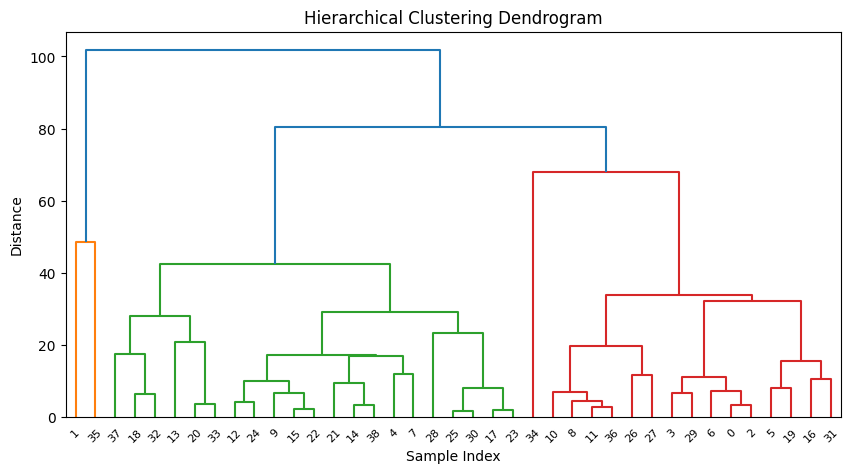

In [20]:
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage
Z = linkage(df, method='ward')

# 绘制层次聚类的树状图
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()